Loading images from category: spidermite and subfolder: Tomato__spidermite
Loading images from category: bacterialspot and subfolder: Tomato___Bacterialspot
Loading images from category: earlyblight and subfolder: Tomato___Earlyblight
Loading images from category: healthy and subfolder: Tomato___healthy
Loading images from category: lateblight and subfolder: Tomato___Lateblight
Loading images from category: leafmold and subfolder: Tomato___Leafmold
Loading images from category: septorialeafspot and subfolder: Tomato___Septorialeafspot
Loading images from category: targetspot and subfolder: Tomato___Targetspot
Loading images from category: mosaicvirus and subfolder: Tomato___Tomato_mosaicvirus
Loading images from category: yellowleafcurlvirus and subfolder: Tomato___Tomato_yellowleafcurlvirus
Loading images from category: bacterialspot and subfolder: Tomato___Bacterialspot
Loading images from category: earlyblight and subfolder: Tomato___Earlyblight
Loading images from category: healthy

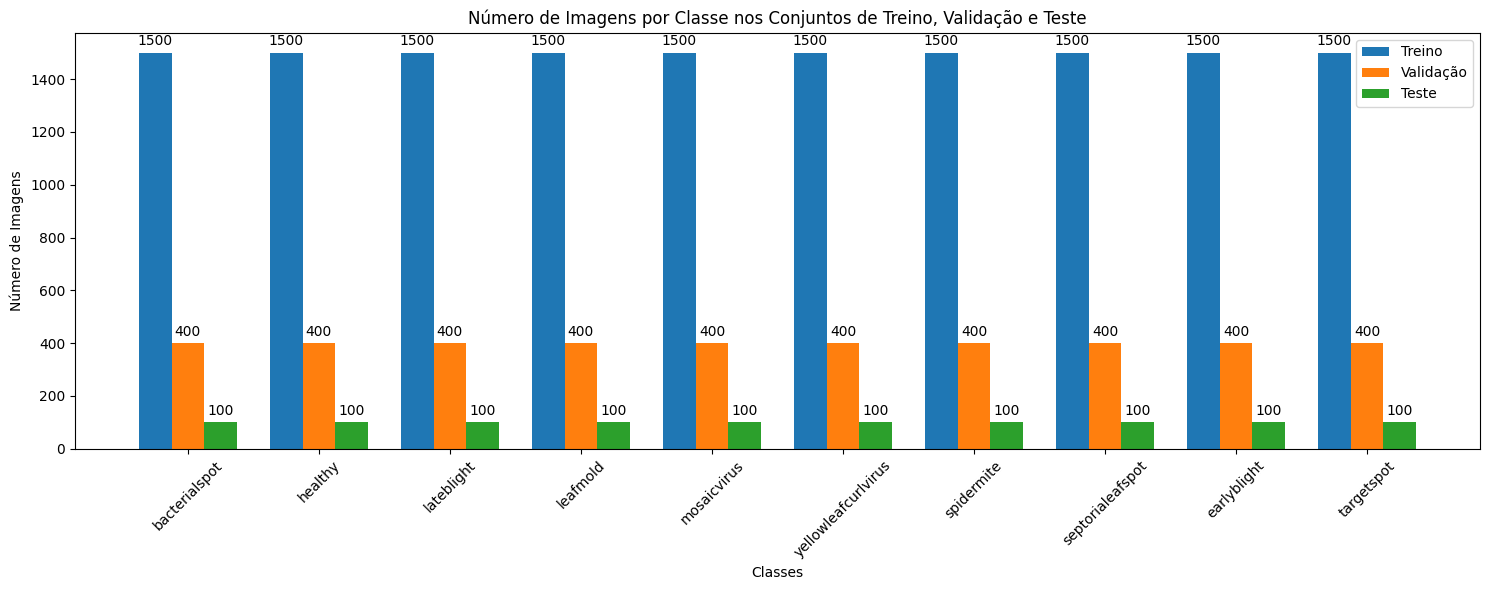

In [3]:
import os
import numpy as np
from PIL import Image
import tensorflow as tf

from utils.duarte_utils import DuarteUtils
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model

from sklearn.model_selection import train_test_split

train_dir = "..\isec-ic\\dataset\\train"
validation_dir = "..\isec-ic\\dataset\\valid"
test_dir = "..\isec-ic\\dataset\\test"

current_dir = os.path.dirname(os.path.realpath(__file__ if '__file__' in locals() else os.getcwd()))
train_dir = os.path.join(current_dir, train_dir)
validation_dir = os.path.join(current_dir, validation_dir)
test_dir = os.path.join(current_dir, test_dir)
#categories = ["bacterialspot", "healthy","lateblight","leafmold", "mosaicvirus","yellowleafcurlvirus" ,"spidermite","septorialeafspot"]
categories = ["bacterialspot", "healthy","lateblight","leafmold", "mosaicvirus","yellowleafcurlvirus" ,"spidermite","septorialeafspot", "earlyblight",  "targetspot"]

def load_images_from_folder(folder):
    images = []
    labels = []
    subfolders = os.listdir(folder)
    for subfolder in subfolders:
        category = subfolder.split("_")[-1].lower()
        if category in categories:
            print("Loading images from category: " + category + " and subfolder: " + subfolder)
            subfolder_path = os.path.join(folder, subfolder)
            for filename in os.listdir(subfolder_path):
                img = Image.open(os.path.join(subfolder_path, filename))
                img = img.resize((64, 64))
                img = np.array(img) / 255.0
                images.append(img)
                labels.append(categories.index(category))
        else:
            print("Category: " + category + " from subfolder " + subfolder + " is not in the list of categories.")
    return np.array(images), np.array(labels)

x_train, y_train = load_images_from_folder(train_dir)
x_validation, y_validation = load_images_from_folder(validation_dir)
x_test, y_test = load_images_from_folder(test_dir)

print("Images loaded successfully")

print(f"Total de imagens no conjunto de treino: {x_train.shape[0]}")
print(f"Total de imagens no conjunto de validação: {x_validation.shape[0]}")
print(f"Total de imagens no conjunto de teste: {x_test.shape[0]}")

DuarteUtils.display_folder_distributions(y_train, y_validation, y_test, categories)

In [2]:
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization

def create_cnn_model(dropout_rate, learning_rate):
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(64, 64, 3))

    for layer in base_model.layers:
        layer.trainable = False

    # Tornar as últimas n camadas treináveis
    n_trainable_layers = 3
    for layer in base_model.layers[-n_trainable_layers:]:
        layer.trainable = True
        
    x = base_model.output
    x = Flatten()(x) 
    x = Dense(128, activation='relu')(x)  
    x = BatchNormalization()(x)
    x = Dropout(dropout_rate)(x)
    predictions = Dense(len(categories), activation='softmax')(x)  # Output layer

    model = Model(inputs=base_model.input, outputs=predictions)

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [8]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

best_learning_rate = 0.001
dropout_rate = 0.225

val_accuracy_threshold = 0.965
early_stopping = EarlyStopping(monitor='val_loss', patience=20, min_delta=0.001, mode='min', verbose=1)
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', save_best_only=True, verbose=0)

while True:
    print("A trainar o modelo...")
    best_model = create_cnn_model(dropout_rate, best_learning_rate)
    best_model_history = best_model.fit(x_train, y_train, epochs=60, batch_size=32, verbose=1, validation_data=(x_validation, y_validation),callbacks=[early_stopping, model_checkpoint])
    
    best_pso_train_accuracy = best_model_history.history['accuracy'][-1]
    best_pso_validation_accuracy = max(best_model_history.history['val_accuracy'])


    print("Melhor Accuracy de Treino: ", best_pso_train_accuracy)
    print("Melhor Accuracy de Validação: ", best_pso_validation_accuracy)

    if best_pso_validation_accuracy >= val_accuracy_threshold:
        print("Atingiu a acurácia desejada no conjunto de validação.")
        break

best_model = load_model('best_model.h5')

loss_test, test_accuracy = best_model.evaluate(x_test, y_test, verbose=0)
print(f"Acurácia no Teste: {test_accuracy}, Loss: {loss_test}")

plt.plot(best_model_history.history['accuracy'], label='Treinamento')
plt.plot(best_model_history.history['val_accuracy'], label='Validação')
plt.xlabel('Épocas')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Treinando o modelo...
Epoch 1/60
375/375 [==============================] - 4s 8ms/step - loss: 0.7734 - accuracy: 0.7482 - val_loss: 0.5938 - val_accuracy: 0.8034
Epoch 2/60
375/375 [==============================] - 4s 11ms/step - loss: 0.2928 - accuracy: 0.9085 - val_loss: 0.4548 - val_accuracy: 0.8434
Epoch 3/60
375/375 [==============================] - 3s 8ms/step - loss: 0.2011 - accuracy: 0.9325 - val_loss: 0.8840 - val_accuracy: 0.7497
Epoch 4/60
375/375 [==============================] - 3s 8ms/step - loss: 0.1476 - accuracy: 0.9538 - val_loss: 0.6161 - val_accuracy: 0.8303
Epoch 5/60
375/375 [==============================] - 3s 7ms/step - loss: 0.1209 - accuracy: 0.9598 - val_loss: 0.6873 - val_accuracy: 0.8112
Epoch 6/60
375/375 [==============================] - 3s 7ms/step - loss: 0.1042 - accuracy: 0.9684 - val_loss: 0.3701 - val_accuracy: 0.8922
Epoch 7/60
375/375 [==============================] - 3s 7ms/step - loss: 0.0881 - accuracy: 0.9709 - val_loss: 0.1635 - val_

ResourceExhaustedError: 2 root error(s) found.
  (0) Resource exhausted:  OOM when allocating tensor with shape[32,64,64,3] and type float on /job:localhost/replica:0/task:0/device:CPU:0 by allocator cpu
	 [[{{node GatherV2}}]]
	 [[IteratorGetNext]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

  (1) Resource exhausted:  OOM when allocating tensor with shape[32,64,64,3] and type float on /job:localhost/replica:0/task:0/device:CPU:0 by allocator cpu
	 [[{{node GatherV2}}]]
	 [[IteratorGetNext]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[IteratorGetNext/_2]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

0 successful operations.
0 derived errors ignored. [Op:__inference_test_function_1025995]

Function call stack:
test_function -> test_function


In [7]:
print("Avaliando o modelo no conjunto de teste...")
loss_test, test_accuracy = best_model.evaluate(x_test, y_test, verbose=0)

print(f"Acurácia no Teste: {test_accuracy}, Loss: {loss_test}")

Avaliando o modelo no conjunto de teste...
Acurácia no Teste: 0.9612500071525574, Loss: 0.1891903281211853


In [5]:
import uuid

# Formatar a acurácia para obter as três primeiras casas decimais
formatted_accuracy = int(test_accuracy * 1000)
# Gerar um GUID único para o nome do arquivo
unique_filename = str(uuid.uuid4())
# Salve o modelo com o nome de arquivo GUID e a acurácia formatada
best_model.save(f'model_{formatted_accuracy}_{unique_filename}.h5')

In [ ]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

# Binarize as etiquetas em um formato one-vs-all
y_test_binarized = label_binarize(y_test, classes=np.arange(len(categories)))

# Calcular a curva ROC e AUC para cada classe
fpr = dict()
tpr = dict()
roc_auc = dict()
for i, category in enumerate(categories):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plotar a curva ROC para cada classe
plt.figure(figsize=(10, 8))
for i, category in enumerate(categories):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'ROC curve of class {category} (area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Each Class')
plt.legend(loc="lower right")
plt.show()